In [25]:
# 25 May 2025

<h1 style="line-height:3rem;"> Women Football Team </h1>

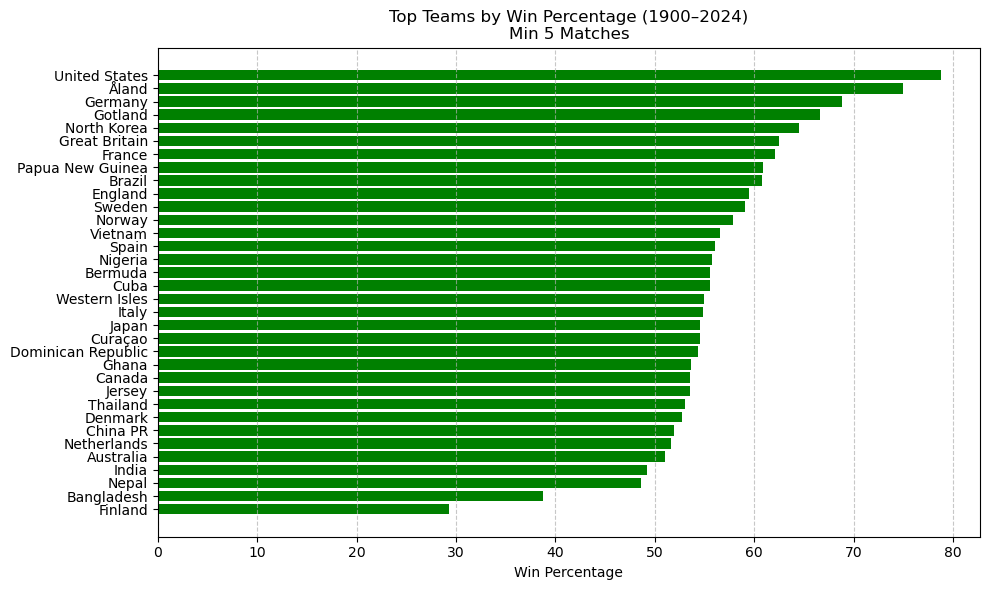

,team,matches,wins,win_percentage
0,United States,575,453,78.78%
1,Åland,32,24,75.00%
2,Germany,385,265,68.83%
3,Gotland,21,14,66.67%
4,North Korea,186,120,64.52%
5,Great Britain,8,5,62.50%
6,France,327,203,62.08%
7,Papua New Guinea,87,53,60.92%
8,Brazil,298,181,60.74%
9,England,336,200,59.52%


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import os

# Detect environment and load data
cwd = os.getcwd()
env_name = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', 'Localhost')

if env_name == "Localhost":
    df = pd.read_csv('../datasets/New/Women_Football.csv')
else:
    df = pd.read_csv("/kaggle/input/women-football/Women_Football.csv")

# Ensure 'date' is in datetime format
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['date'])  # Drop rows with invalid/missing dates


def get_top_teams_by_win_percentage(df, start_year=1900, end_year=2024, top_n=20, min_match=5, include_countries=None, return_plot=True):
    if include_countries is None:
        include_countries = []

    # Filter by year range
    df['year'] = df['date'].dt.year
    df = df[(df['year'] >= start_year) & (df['year'] <= end_year)]

    # Collect match stats
    team_stats = {}

    for _, row in df.iterrows():
        home, away = row['home_team'], row['away_team']
        home_score, away_score = row['home_score'], row['away_score']

        for team in [home, away]:
            if team not in team_stats:
                team_stats[team] = {'matches': 0, 'wins': 0}

        team_stats[home]['matches'] += 1
        team_stats[away]['matches'] += 1

        if home_score > away_score:
            team_stats[home]['wins'] += 1
        elif away_score > home_score:
            team_stats[away]['wins'] += 1

    # Create stats DataFrame
    stats = [
        {
            'team': team,
            'matches': data['matches'],
            'wins': data['wins'],
            'win_percentage': round((data['wins'] / data['matches']) * 100, 2)
        }
        for team, data in team_stats.items() if data['matches'] >= min_match
    ]

    df_stats = pd.DataFrame(stats)

    # Add required countries even if they don't meet min_match or top_n
    for country in include_countries:
        if country not in df_stats['team'].values:
            data = team_stats.get(country)
            if data and data['matches'] > 0:
                df_stats = pd.concat([
                    df_stats,
                    pd.DataFrame([{
                        'team': country,
                        'matches': data['matches'],
                        'wins': data['wins'],
                        'win_percentage': round((data['wins'] / data['matches']) * 100, 2)
                    }])
                ], ignore_index=True)

    # Drop duplicates just in case (retain first instance)
    df_stats = df_stats.drop_duplicates(subset='team')

    # Get top teams + required countries
    df_top = df_stats.sort_values(by='win_percentage', ascending=False).head(top_n)

    # Ensure include_countries are in the final table
    df_include = df_stats[df_stats['team'].isin(include_countries)]
    df_combined = pd.concat([df_top, df_include]).drop_duplicates(subset='team').reset_index(drop=True)
    df_combined = df_combined.sort_values(by='win_percentage', ascending=False).reset_index(drop=True)

    # Style the table
    styled_df = df_combined.style.background_gradient(subset=['win_percentage'], cmap='Greens').format({
        'win_percentage': '{:.2f}%',
        'matches': '{:,.0f}',
        'wins': '{:,.0f}'
    })

    # Bar chart
    if return_plot:
        plt.figure(figsize=(10, 6))
        plt.barh(df_combined['team'][::-1], df_combined['win_percentage'][::-1], color='green')
        plt.xlabel('Win Percentage')
        plt.title(f'Top Teams by Win Percentage ({start_year}–{end_year})\nMin {min_match} Matches')
        plt.grid(axis='x', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

    return styled_df


# Example usage
styled_table = get_top_teams_by_win_percentage(
    df,
    start_year=1900,
    end_year=2024,
    top_n=30,
    min_match=5,
    include_countries=["Finland", "Sweden", "Bangladesh", "Nepal", "India"]
)

# Display styled table in notebook
styled_table


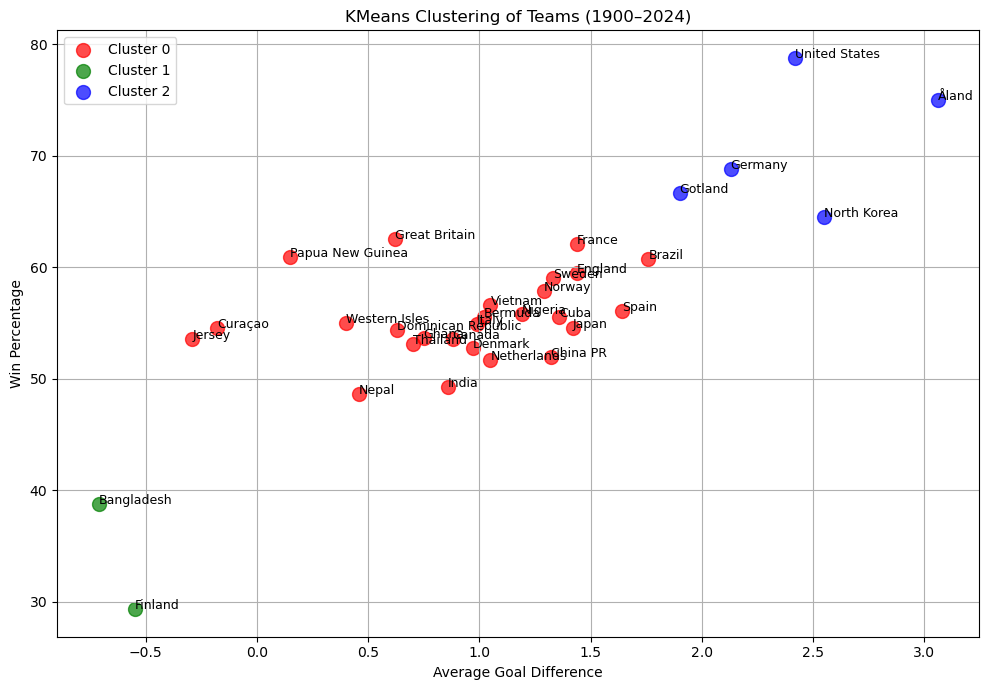

,team,matches,wins,win_percentage,avg_goal_difference,cluster
16,Cuba,45,25,55.56%,1.36,0
24,Jersey,28,15,53.57%,-0.29,0
23,Canada,334,179,53.59%,0.88,0
22,Ghana,123,66,53.66%,0.75,0
21,Dominican Republic,46,25,54.35%,0.63,0
20,Curaçao,11,6,54.55%,-0.18,0
19,Japan,372,203,54.57%,1.42,0
18,Italy,359,197,54.87%,0.99,0
17,Western Isles,20,11,55.00%,0.40,0
32,Nepal,74,36,48.65%,0.46,0


In [32]:
def clustering_team(
    file_path,
    start_year=1900, 
    end_year=2024, 
    top_n=30, 
    min_match=5,
    include_countries=["Finland", "Sweden"],
    n_clusters=3
):
    # Load dataset
    df = pd.read_csv(file_path, parse_dates=['date'])

    # Filter by year
    df['year'] = df['date'].dt.year
    df = df[(df['year'] >= start_year) & (df['year'] <= end_year)]

    # Initialize team stats
    team_stats = {}

    for _, row in df.iterrows():
        home, away = row['home_team'], row['away_team']
        home_score, away_score = row['home_score'], row['away_score']

        for team in [home, away]:
            if team not in team_stats:
                team_stats[team] = {'matches': 0, 'wins': 0, 'goals_for': 0, 'goals_against': 0}

        team_stats[home]['matches'] += 1
        team_stats[away]['matches'] += 1

        team_stats[home]['goals_for'] += home_score
        team_stats[home]['goals_against'] += away_score

        team_stats[away]['goals_for'] += away_score
        team_stats[away]['goals_against'] += home_score

        if home_score > away_score:
            team_stats[home]['wins'] += 1
        elif away_score > home_score:
            team_stats[away]['wins'] += 1

    # Prepare dataframe
    stats = []
    for team, data in team_stats.items():
        if data['matches'] >= min_match:
            win_pct = (data['wins'] / data['matches']) * 100
            avg_goal_diff = (data['goals_for'] - data['goals_against']) / data['matches']
            stats.append({
                'team': team,
                'matches': data['matches'],
                'wins': data['wins'],
                'win_percentage': round(win_pct, 2),
                'avg_goal_difference': round(avg_goal_diff, 2)
            })

    df_stats = pd.DataFrame(stats)

    # Add required countries even if they don't meet min_match
    for country in include_countries:
        if country not in df_stats['team'].values:
            data = team_stats.get(country)
            if data and data['matches'] > 0:
                win_pct = (data['wins'] / data['matches']) * 100
                avg_goal_diff = (data['goals_for'] - data['goals_against']) / data['matches']
                df_stats = pd.concat([
                    df_stats,
                    pd.DataFrame([{
                        'team': country,
                        'matches': data['matches'],
                        'wins': data['wins'],
                        'win_percentage': round(win_pct, 2),
                        'avg_goal_difference': round(avg_goal_diff, 2)
                    }])
                ], ignore_index=True)

    # Drop duplicates and sort
    df_stats = df_stats.drop_duplicates(subset='team')
    df_top = df_stats.sort_values(by='win_percentage', ascending=False).head(top_n)

    # Combine with include_countries
    df_include = df_stats[df_stats['team'].isin(include_countries)]
    df_combined = pd.concat([df_top, df_include]).drop_duplicates(subset='team').reset_index(drop=True)

    # Drop rows with NaNs before clustering
    df_combined = df_combined.dropna(subset=['avg_goal_difference', 'win_percentage'])

    # KMeans Clustering
    X = df_combined[['avg_goal_difference', 'win_percentage']].values
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    df_combined['cluster'] = kmeans.fit_predict(X)

    # Plot
    plt.figure(figsize=(10, 7))
    colors = ['red', 'green', 'blue', 'purple', 'orange']
    for cluster in range(n_clusters):
        cluster_df = df_combined[df_combined['cluster'] == cluster]
        plt.scatter(
            cluster_df['avg_goal_difference'],
            cluster_df['win_percentage'],
            label=f'Cluster {cluster}',
            s=100,
            alpha=0.7,
            color=colors[cluster % len(colors)]
        )
    for _, row in df_combined.iterrows():
        plt.text(row['avg_goal_difference'], row['win_percentage'], row['team'], fontsize=9)

    plt.xlabel("Average Goal Difference")
    plt.ylabel("Win Percentage")
    plt.title(f"KMeans Clustering of Teams ({start_year}–{end_year})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Style table
    styled_table = df_combined.sort_values(by='cluster').style.background_gradient(
        subset=['win_percentage', 'avg_goal_difference'], cmap='RdYlGn'
    ).format({
        'win_percentage': '{:.2f}%',
        'avg_goal_difference': '{:.2f}',
        'matches': '{:,.0f}',
        'wins': '{:,.0f}',
        'cluster': '{:,.0f}'
    })

    return styled_table



file_path = '../datasets/New/Women_Football.csv'
clustered_teams = clustering_team(
    file_path=file_path,
    start_year=1900,
    end_year=2024,
    top_n=30,
    min_match=5,
    include_countries=["Finland", "Sweden", "Bangladesh", "Nepal", "India"],
    n_clusters=3
)
clustered_teams
